In [1]:
import torch
import librosa
import numpy as np
from src.model import HybridCNNGRUWithAttention
import os
from skimage.transform import resize
from src.dataset import normalize_peak
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [5]:
CLASS_NAMES = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']

BEST_MODEL_PATH = 'data/models/best_gru_with_attention_model_2.pth'

In [3]:
def preprocess_audio_file(audio_path, resized_shape=(150, 150)):
    spectrograms = []
        
    if audio_path.lower().endswith(('.wav', '.mp3')):
        audio, rate = librosa.load(audio_path, sr=None)
        audio = normalize_peak(audio)  # Apply peak normalization
        
        duration_of_chunk = 4  # seconds
        overlap = 2  # seconds
        samples_per_chunk = duration_of_chunk * rate
        samples_overlap = overlap * rate
        total_chunks = int(np.ceil((len(audio) - samples_per_chunk) / (samples_per_chunk - samples_overlap))) + 1
        
        for chunk_number in range(total_chunks):
            start_sample = chunk_number * (samples_per_chunk - samples_overlap)
            end_sample = start_sample + samples_per_chunk
            audio_chunk = audio[start_sample:end_sample]
            mel_spect = librosa.feature.melspectrogram(y=audio_chunk, sr=rate)
            resized_mel_spect = resize(np.expand_dims(mel_spect, axis=-1), resized_shape)
            spectrograms.append(resized_mel_spect)
    
    return np.array(spectrograms)

def test_single_file(file_path):
    # Load and preprocess the audio file
    spectrograms = preprocess_audio_file(file_path)
    X = torch.FloatTensor(spectrograms).permute(0, 3, 1, 2)
    
    # Load model if not already loaded
    model_path = BEST_MODEL_PATH
    model = HybridCNNGRUWithAttention()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        output = model(X)
        # Average predictions across chunks
        avg_pred = output.mean(dim=0)
        predicted_class = torch.argmax(avg_pred).item()
        
        # Get probabilities for all classes
        probabilities = torch.nn.functional.softmax(avg_pred, dim=0)
        
    # Print results
    print(f"\nPredicted genre: {CLASS_NAMES[predicted_class]}")
    print("\nProbabilities for each genre:")
    for i, (genre, prob) in enumerate(zip(CLASS_NAMES, probabilities)):
        print(f"{genre}: {prob:.4f}")

### Test individual file

In [8]:
filepath = "data/test_files/pop/pop7_cantstopthefeeling.mp3"

# Check if file exists
if os.path.exists(filepath):
    test_single_file(filepath)
else:
    print(f"Error: File '{filepath}' does not exist.")


Predicted genre: Pop

Probabilities for each genre:
Blues: 0.0000
Classical: 0.0000
Country: 0.0000
Disco: 0.0004
Hiphop: 0.0009
Jazz: 0.0000
Metal: 0.0000
Pop: 0.9985
Reggae: 0.0000
Rock: 0.0001


### Test sample files

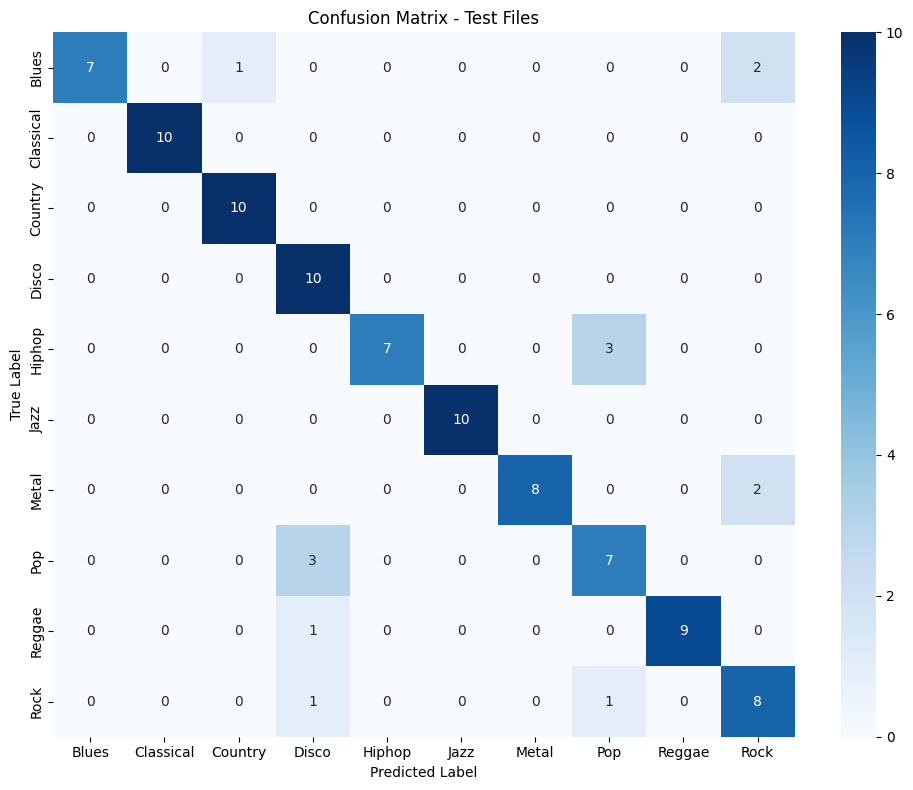


Test Files Evaluation Metrics:
Accuracy: 0.8600
Precision: 0.8879
Recall: 0.8600
F1 Score: 0.8630


In [9]:
# Load trained model
model = HybridCNNGRUWithAttention()
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# Initialize lists
all_true_labels = []
all_predictions = []
misclassified_files = []

# Process each genre folder
test_files_dir = 'data/test_files'
for genre_idx, genre in enumerate(CLASS_NAMES):
    genre_dir = os.path.join(test_files_dir, genre.lower())
    if os.path.exists(genre_dir):
        for audio_file in os.listdir(genre_dir):
            if audio_file.endswith(('.wav', '.mp3')):
                audio_path = os.path.join(genre_dir, audio_file)
                
                # Preprocess audio
                spectrograms = preprocess_audio_file(audio_path)
                X = torch.FloatTensor(spectrograms).permute(0, 3, 1, 2)
                
                # Make prediction
                with torch.no_grad():
                    output = model(X)
                    # Average predictions across chunks
                    avg_pred = output.mean(dim=0)
                    predicted_class = torch.argmax(avg_pred).item()
                
                all_true_labels.append(genre_idx)
                all_predictions.append(predicted_class)
                
                # Check if prediction is wrong
                if predicted_class != genre_idx:
                    misclassified_files.append({
                        'file': audio_file,
                        'true_genre': CLASS_NAMES[genre_idx],
                        'predicted_genre': CLASS_NAMES[predicted_class]
                    })

# Calculate metrics and create confusion matrix
accuracy = accuracy_score(all_true_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Save metrics
metrics = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1)
}

os.makedirs('output/metrics', exist_ok=True)
with open('output/metrics/test_files_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Test Files')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
plt.close()

# Print metrics
print("\nTest Files Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")